## 모듈, 함수 불러오기

In [1]:
from PIL import Image, ImageFont, ImageDraw, ImageChops, ImageOps
from glob import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
from time import sleep
from funcs import get_opt
import multiprocessing as mp
from functools import partial
from tqdm import tqdm

## 마스크와 이미지 크기 정의

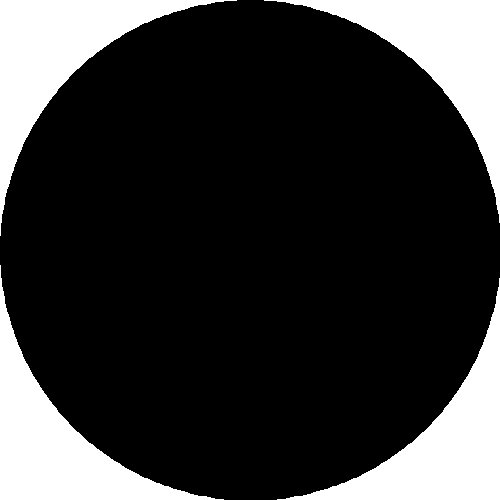

In [2]:
image_size = (500, 500)

# 동글이 마스크 생성
mask = Image.new("L", image_size, 255)
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, image_size[0], image_size[1]), fill=0)

# 하트 마스크 생성
# mask = Image.open('./마스크들/heart.png').convert('L').resize(image_size)

# 별 마스크 생성
# mask = Image.open('./마스크들/star.png').convert('L').resize(image_size)


mask

## 클래스 정의

In [3]:
class FontImage():
    W, H = image_size
    font = 'Maplestory Light.ttf'
#     font = 'Typo_DabangguB.ttf'
#     font = 'DXSeNB-KSCpc-EUC-H.ttf'
    mask_im = mask
    
    def __init__(self, msg, font_size, font=font, color='green', padding_size=1):
        _w, _h = FontImage.W, FontImage.H
        self.font = ImageFont.truetype(font, font_size)
        self.board = Image.new("RGBA",(_w, _h),"black")
        self.input_text(_w, _h, msg, color)
        self.padding_size = padding_size
        self.img_sync()
        temp_img = Image.blend(FontImage.mask_im, self.padding, alpha=0.5) #이미지 겹쳐본다
        if self.check_overlap(temp_img):
            raise Exception('font size is so big..')
    
    def input_text(self, W, H, msg, color):
        draw = ImageDraw.Draw(self.board)
        w, h = draw.textsize(msg, font=self.font)
        self.font_loc = ((W-w)/2,(H-h)/2)
        draw.text(self.font_loc, msg, fill=color, font=self.font)
        
    def img_sync(self): ######################
        self.padding = self.board.convert('L') # 회색으로
        p = np.array(self.padding)
        p[p>0] = 255
        self.padding = Image.fromarray(p) ###########
        self.mask = copy.deepcopy(self.padding) ############
        self.padder()
    
    def padder(self):
        padding = copy.deepcopy(self.padding)
        for i in range(-1*self.padding_size, self.padding_size+1):
            self.padding.paste(padding, (i,0), padding)
        
        padding = copy.deepcopy(self.padding)
        for i in range(-1*self.padding_size, self.padding_size+1):
            self.padding.paste(padding, (0,i), padding)

    def input_img(self, image):
        loc = self.get_happy_loc(image)
        if loc == None:
            print('none')
            return 1
        mask = image.board.convert('L')
        self.board.paste(ImageChops.offset(image.board, loc[0], loc[1]), \
                         (0,0), \
                         ImageChops.offset(image.mask, loc[0], loc[1]))
        self.img_sync()
        
        return 0
        
    def get_happy_loc(self, image):
        distance = 9999 # 중앙으로 부터의 거리
        x, y = None, None
        w = int(image.font_loc[0]) - self.padding_size
        h = int(image.font_loc[1]) - self.padding_size

            
#         for k in range(1000):
#             i = np.random.randint(-1*w, w+1)
#             j = np.random.randint(-1*h, h+1)
# #         for i in range(-1*w, w+1):
# #             for j in range(-1*h, h+1):
# #                 print(i, j)

# #             M = np.float32([[1, 0, i], [0, 1, j]]) # 이미지 이동
# #             image_trans = cv2.warpAffine(image.padding, M, (image.W, image.H)) # 이미지 이동
#             image_trans = ImageChops.offset(image.padding, i, j)

#             temp_img = Image.blend(self.padding, image_trans, alpha=0.5) #이미지 겹쳐본다
#             if self.check_overlap(temp_img):
#                 continue

#             d = np.linalg.norm([i,j]) # 유클리드 거리
#             if distance > d:
#                 distance = d
#                 x, y = i, j


        dist_list = get_opt_loc(get_opt, self.padding, image.padding, FontImage.mask_im, w, h) # 멀티 프로세싱으로 바꿨음
        
        for v in dist_list:
            if v == None:
                continue
            
            i, j, d = v
            
            if distance > d:
                distance = d
                x, y = i, j
    
        
        if distance == 9999:
            return None
        
#         print(x,y)
        
        return x, y
        
    def check_overlap(self, img):
#         global tttt
#         tttt = copy.deepcopy(img)
        img = np.array(img)
        for i in range(130, 256):
            if i in img:
                return True
            
        return False
                

# tttt = None  

## 멀티프로세싱 in class

In [4]:
def get_opt_loc(func, img1, img2, mask, w, h, num=500):
    func_fixed = partial(func, img1=img1, img2=img2, mask=mask, w=w, h=h)
    
    if __name__ == '__main__':
        with mp.Pool(processes = mp.cpu_count()) as pool:
    #         _list = list(pool.imap(func_fixed, files_path))
            _list = list(tqdm(pool.imap(func_fixed, range(num)), total = num))
    
    return _list

## 단어 가져오기

In [6]:
str_list = np.load('./npy/sw.npy')
print(len(str_list))
str_list

2442


array(['ㅋㅋ', '?', '오', ..., '않2', '제섭는', '불편'], dtype='<U20')

## 만들기

In [7]:
str_list = str_list[8:]

In [8]:
sizes = [120]*1 + [60]*2 + [40]*7 + [30]*15 + [24]*30 + [20]*45
len(sizes)

100

100%|██████████| 500/500 [00:03<00:00, 139.77it/s]


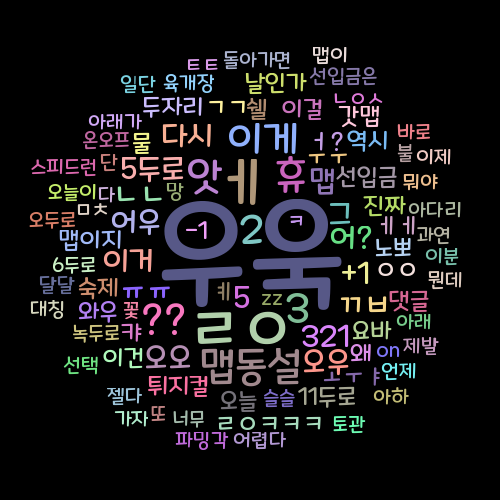

In [9]:
base_img = FontImage(str_list[0], sizes[0], color=(np.random.randint(0,255), \
                                                   np.random.randint(0,255), \
                                                   np.random.randint(0,255)))
ind = 1
for s in str_list[1:100]:
    r, g, b = np.random.randint(100,255), np.random.randint(100,255), np.random.randint(100,255)
    flag = 1
    cnt = 0
    size = sizes[ind]
    while flag == 1 and cnt < 5: # 안들어가면 줄여서 계속  # 5번반복해도 안들어가면 나가기
        img = FontImage(s, size, color=(r,g,b))
        flag = base_img.input_img(img)
        if flag == 1 and size > 5:
            size -= 5
        cnt += 1
        
    if cnt >= 5:
        print('Early Stop')
        break
    ind += 1

base_img.board

## 이미지 저장

In [10]:
base_img.board.save('./동글들/동글_20_9_14_원.png')

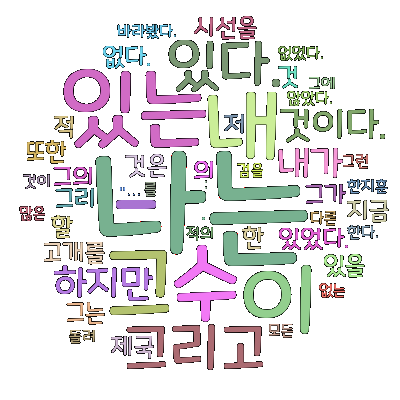

In [43]:
nega = np.array(base_img.board)[:,:,:3]
nega += 255
nega = Image.fromarray(nega)
nega

In [7]:
img = FontImage('ㅗㅜㅑ', 60, color=(0,255,0))
img.board

ValueError: images do not match

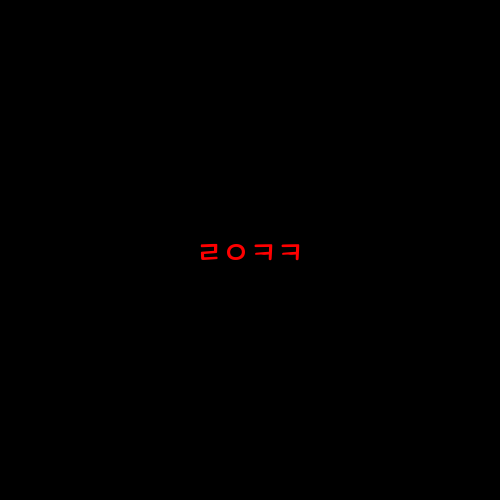

In [22]:
img2 = FontImage('ㄹㅇㅋㅋ', 30, color=(255,0,0))
img2.board

100%|██████████| 1000/1000 [00:02<00:00, 488.28it/s]


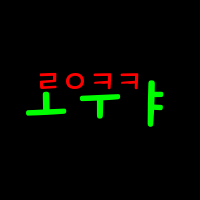

In [24]:
img.input_img(img2)
img.board

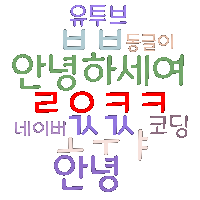

In [46]:
base = np.array(base_img.board)[:,:,:3]
base = base.reshape(-1,3)
for i in range(len(base)):
    if base[i][0] < 100 and \
        base[i][1] < 100 and \
        base[i][2] < 100:
        base[i][0] = 255
        base[i][1] = 255
        base[i][2] = 255

base = base.reshape(200,200,3)

new_base_img = Image.fromarray(base)
new_base_img

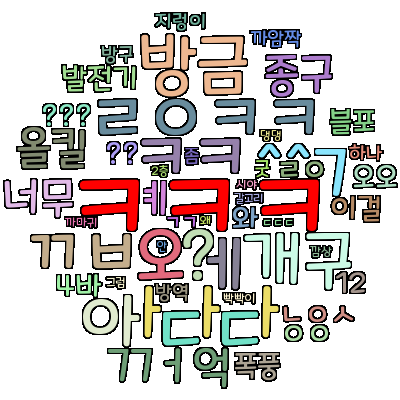

In [20]:
white = Image.new("RGBA", (FontImage.W, FontImage.H), (255,255,255))
white.paste(base_img.board, (0,0), base_img.padding)
white